# **Movie Recommendation System**

In today’s fast-paced world, where time is constantly in short supply, recommendation systems have become essential. With a multitude of tasks to complete in just 24 hours, people often struggle to make informed decisions. These systems play a crucial role by helping individuals navigate choices more efficiently, alleviating the mental burden of decision-making and saving valuable time.

First, I'll start by creating the baseline model. Then, I'll upgrade it by incorporating new features and techniques. Finally, I'll build the advanced model using XGBoost. Let's begin this exciting journey!

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movie-recommendation-system/movies.csv
/kaggle/input/movie-recommendation-system/ratings.csv


In [2]:
import numpy as np
import warnings 
warnings.filterwarnings("ignore")
import pandas as pd

In [3]:
# donwload datasets
movies = pd.read_csv("/kaggle/input/movie-recommendation-system/movies.csv")
ratings = pd.read_csv("/kaggle/input/movie-recommendation-system/ratings.csv")

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [6]:
rating_df = ratings[:200000]
rating_df

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
199995,1409,48516,4.0,1287843475
199996,1409,48696,4.0,1287854818
199997,1409,48738,3.5,1287854109
199998,1409,48774,4.0,1287849077


In [7]:
mean_user_rating = (
    ratings
    .groupby("userId")
    ["rating"]
    .mean()
)
mean_user_rating

userId
1         3.814286
2         3.630435
3         3.697409
4         3.378099
5         3.752475
            ...   
162537    4.039604
162538    3.415584
162539    4.510638
162540    3.829545
162541    3.365385
Name: rating, Length: 162541, dtype: float64

In [8]:
# Partition the data - denormalization
rating_df = rating_df.merge(mean_user_rating, how="left", on="userId", suffixes=("","_user_mean"))
rating_df

,userId,movieId,rating,timestamp,rating_user_mean
0,1,296,5.0,1147880044,3.814286
1,1,306,3.5,1147868817,3.814286
2,1,307,5.0,1147868828,3.814286
3,1,665,5.0,1147878820,3.814286
4,1,899,3.5,1147868510,3.814286
...,...,...,...,...,...
199995,1409,48516,4.0,1287843475,3.043624
199996,1409,48696,4.0,1287854818,3.043624
199997,1409,48738,3.5,1287854109,3.043624
199998,1409,48774,4.0,1287849077,3.043624


In [9]:
# Add an average movie rating - averaging across all user ratings
mean_movies_rating = (
    ratings
    .groupby("movieId")
    ["rating"]
    .mean()
)
mean_movies_rating

movieId
1         3.893708
2         3.251527
3         3.142028
4         2.853547
5         3.058434
            ...   
209157    1.500000
209159    3.000000
209163    4.500000
209169    3.000000
209171    3.000000
Name: rating, Length: 59047, dtype: float64

In [10]:
# Partition the data - denormalization
movies = movies.merge(mean_movies_rating, how="left", on="movieId").rename({"rating": "rating_movie_mean"}, axis=1)
movies

,movieId,title,genres,rating_movie_mean
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547
4,5,Father of the Bride Part II (1995),Comedy,3.058434
...,...,...,...,...
62418,209157,We (2018),Drama,1.500000
62419,209159,Window of the Soul (2001),Documentary,3.000000
62420,209163,Bad Poems (2018),Comedy|Drama,4.500000
62421,209169,A Girl Thing (2001),(no genres listed),3.000000


In [11]:
rating_df["datetime"] = (
    pd.to_datetime(rating_df["timestamp"], unit="s")
)
rating_df

,userId,movieId,rating,timestamp,rating_user_mean,datetime
0,1,296,5.0,1147880044,3.814286,2006-05-17 15:34:04
1,1,306,3.5,1147868817,3.814286,2006-05-17 12:26:57
2,1,307,5.0,1147868828,3.814286,2006-05-17 12:27:08
3,1,665,5.0,1147878820,3.814286,2006-05-17 15:13:40
4,1,899,3.5,1147868510,3.814286,2006-05-17 12:21:50
...,...,...,...,...,...,...
199995,1409,48516,4.0,1287843475,3.043624,2010-10-23 14:17:55
199996,1409,48696,4.0,1287854818,3.043624,2010-10-23 17:26:58
199997,1409,48738,3.5,1287854109,3.043624,2010-10-23 17:15:09
199998,1409,48774,4.0,1287849077,3.043624,2010-10-23 15:51:17


In [12]:
# Let's get the time signatures 
rating_df["year"]=rating_df["datetime"].dt.year
rating_df["month"]=rating_df["datetime"].dt.month
rating_df["day_of_week"]=rating_df["datetime"].dt.day_of_week
rating_df["day"]=rating_df["datetime"].dt.day
rating_df["hour"]=rating_df["datetime"].dt.hour
rating_df

,userId,movieId,rating,timestamp,rating_user_mean,datetime,year,month,day_of_week,day,hour
0,1,296,5.0,1147880044,3.814286,2006-05-17 15:34:04,2006,5,2,17,15
1,1,306,3.5,1147868817,3.814286,2006-05-17 12:26:57,2006,5,2,17,12
2,1,307,5.0,1147868828,3.814286,2006-05-17 12:27:08,2006,5,2,17,12
3,1,665,5.0,1147878820,3.814286,2006-05-17 15:13:40,2006,5,2,17,15
4,1,899,3.5,1147868510,3.814286,2006-05-17 12:21:50,2006,5,2,17,12
...,...,...,...,...,...,...,...,...,...,...,...
199995,1409,48516,4.0,1287843475,3.043624,2010-10-23 14:17:55,2010,10,5,23,14
199996,1409,48696,4.0,1287854818,3.043624,2010-10-23 17:26:58,2010,10,5,23,17
199997,1409,48738,3.5,1287854109,3.043624,2010-10-23 17:15:09,2010,10,5,23,17
199998,1409,48774,4.0,1287849077,3.043624,2010-10-23 15:51:17,2010,10,5,23,15


In [13]:
rating_df = rating_df.drop(columns="datetime", axis = 1)
rating_df

,userId,movieId,rating,timestamp,rating_user_mean,year,month,day_of_week,day,hour
0,1,296,5.0,1147880044,3.814286,2006,5,2,17,15
1,1,306,3.5,1147868817,3.814286,2006,5,2,17,12
2,1,307,5.0,1147868828,3.814286,2006,5,2,17,12
3,1,665,5.0,1147878820,3.814286,2006,5,2,17,15
4,1,899,3.5,1147868510,3.814286,2006,5,2,17,12
...,...,...,...,...,...,...,...,...,...,...
199995,1409,48516,4.0,1287843475,3.043624,2010,10,5,23,14
199996,1409,48696,4.0,1287854818,3.043624,2010,10,5,23,17
199997,1409,48738,3.5,1287854109,3.043624,2010,10,5,23,17
199998,1409,48774,4.0,1287849077,3.043624,2010,10,5,23,15


In [14]:
def get_part_of_day(hour):
    if 5<= hour < 12:
        return "morning"
    elif 12 <= hour < 17:
        return "day"
    elif 17 <= hour < 21:
        return "evening"
    else:
        return "night" 

In [15]:
rating_df["part_of_day"] = rating_df["hour"].apply(get_part_of_day)

In [16]:
rating_df = pd.get_dummies(rating_df, columns=["part_of_day"], prefix = "time")
rating_df

,userId,movieId,rating,timestamp,rating_user_mean,year,month,day_of_week,day,hour,time_day,time_evening,time_morning,time_night
0,1,296,5.0,1147880044,3.814286,2006,5,2,17,15,True,False,False,False
1,1,306,3.5,1147868817,3.814286,2006,5,2,17,12,True,False,False,False
2,1,307,5.0,1147868828,3.814286,2006,5,2,17,12,True,False,False,False
3,1,665,5.0,1147878820,3.814286,2006,5,2,17,15,True,False,False,False
4,1,899,3.5,1147868510,3.814286,2006,5,2,17,12,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,1409,48516,4.0,1287843475,3.043624,2010,10,5,23,14,True,False,False,False
199996,1409,48696,4.0,1287854818,3.043624,2010,10,5,23,17,False,True,False,False
199997,1409,48738,3.5,1287854109,3.043624,2010,10,5,23,17,False,True,False,False
199998,1409,48774,4.0,1287849077,3.043624,2010,10,5,23,15,True,False,False,False


In [17]:
rating_df = rating_df.drop(columns=["timestamp"])
rating_df.head(2)

,userId,movieId,rating,rating_user_mean,year,month,day_of_week,day,hour,time_day,time_evening,time_morning,time_night
0,1,296,5.0,3.814286,2006,5,2,17,15,True,False,False,False
1,1,306,3.5,3.814286,2006,5,2,17,12,True,False,False,False


In [18]:
genres_list = movies["genres"].apply(lambda x: x.split("|") )
genres_list

0        [Adventure, Animation, Children, Comedy, Fantasy]
1                           [Adventure, Children, Fantasy]
2                                        [Comedy, Romance]
3                                 [Comedy, Drama, Romance]
4                                                 [Comedy]
                               ...                        
62418                                              [Drama]
62419                                        [Documentary]
62420                                      [Comedy, Drama]
62421                                 [(no genres listed)]
62422                           [Action, Adventure, Drama]
Name: genres, Length: 62423, dtype: object

In [19]:
# model data preparation 
from sklearn.preprocessing import MultiLabelBinarizer
mlf =  MultiLabelBinarizer()
mlf.fit(genres_list)
list(mlf.classes_)

['(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [20]:
mlf.transform(genres_list)

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

In [21]:
# use indexing like in the movies dataframe to make it easier to merge them together afterwards
genre_encoded = pd.DataFrame(mlf.transform(genres_list), columns=mlf.classes_, index= movies.index)

In [22]:
genre_encoded.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
movies_encoded = pd.concat(
    [movies.drop("genres", axis=1),
    genre_encoded],axis=1)
movies_encoded.head(2)

,movieId,title,rating_movie_mean,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),3.893708,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),3.251527,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
df = rating_df.merge(movies_encoded, how="left", on="movieId")
df

,userId,movieId,rating,rating_user_mean,year,month,day_of_week,day,hour,time_day,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,296,5.0,3.814286,2006,5,2,17,15,True,...,0,0,0,0,0,0,0,1,0,0
1,1,306,3.5,3.814286,2006,5,2,17,12,True,...,0,0,0,0,0,0,0,0,0,0
2,1,307,5.0,3.814286,2006,5,2,17,12,True,...,0,0,0,0,0,0,0,0,0,0
3,1,665,5.0,3.814286,2006,5,2,17,15,True,...,0,0,0,0,0,0,0,0,1,0
4,1,899,3.5,3.814286,2006,5,2,17,12,True,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,1409,48516,4.0,3.043624,2010,10,5,23,14,True,...,0,0,0,0,0,0,0,1,0,0
199996,1409,48696,4.0,3.043624,2010,10,5,23,17,False,...,0,0,0,0,0,1,0,0,0,0
199997,1409,48738,3.5,3.043624,2010,10,5,23,17,False,...,0,0,0,0,0,0,0,1,0,0
199998,1409,48774,4.0,3.043624,2010,10,5,23,15,True,...,0,0,0,0,0,0,1,1,0,0


In [25]:
# we can calculate the average rating of a particular user for a particular movie
mean_genres_by_user = pd.concat(
     [
        df["userId"], 
        df[list(mlf.classes_)].multiply(df["rating"], axis=0) #by column multiplication
     ], axis = 1
 ).groupby("userId").mean()# aggregate by user and find out the average score by genre

mean_genres_by_user

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.235714,0.585714,0.114286,0.164286,1.271429,0.464286,0.028571,2.928571,0.257143,0.050000,0.050000,0.000000,0.264286,0.200000,1.071429,0.264286,0.307143,0.278571,0.035714
2,0.000000,1.326087,1.592391,0.334239,0.497283,1.135870,0.307065,0.000000,1.766304,0.627717,0.000000,0.065217,0.154891,0.195652,0.160326,0.584239,0.611413,0.625000,0.279891,0.067935
3,0.005335,1.853659,1.113567,0.303354,0.271341,0.926829,0.782012,0.014482,1.375762,0.444360,0.032774,0.243140,0.461128,0.032774,0.355945,0.323171,1.262195,1.345274,0.146341,0.045732
4,0.000000,1.909091,1.448347,0.444215,0.371901,1.208678,0.607438,0.084711,0.758264,0.456612,0.000000,0.130165,0.411157,0.105372,0.283058,0.142562,1.111570,0.820248,0.123967,0.105372
5,0.000000,0.663366,0.801980,0.148515,0.297030,1.732673,0.574257,0.000000,1.702970,0.277228,0.000000,0.138614,0.118812,0.257426,0.326733,0.702970,0.445545,0.950495,0.089109,0.148515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1405,0.000000,0.388448,0.297848,0.074745,0.135900,1.556059,0.593431,0.073613,2.151755,0.235561,0.106455,0.148358,0.006795,0.245753,0.272933,0.919592,0.177803,0.652322,0.199320,0.074745
1406,0.000000,0.409091,0.409091,0.454545,0.454545,1.590909,1.318182,0.000000,2.500000,0.000000,0.000000,0.409091,0.000000,0.000000,0.545455,0.590909,0.409091,1.000000,0.863636,0.000000
1407,0.000000,0.539062,0.562500,0.132812,0.320312,2.914062,0.398438,0.023438,0.859375,0.351562,0.015625,0.125000,0.000000,0.343750,0.187500,0.953125,0.304688,0.343750,0.195312,0.156250


Based on the table above, the algorithm can determine which movies or genres the user prefers the most, as well as identify those they are less likely to enjoy or should avoid suggesting. You can observe both the frequency of viewing and the user's overall preferences.

In [26]:
df = df.merge(mean_genres_by_user, how="left", on="userId", suffixes=("","_mean_gen"))
df

,userId,movieId,rating,rating_user_mean,year,month,day_of_week,day,hour,time_day,...,Film-Noir_mean_gen,Horror_mean_gen,IMAX_mean_gen,Musical_mean_gen,Mystery_mean_gen,Romance_mean_gen,Sci-Fi_mean_gen,Thriller_mean_gen,War_mean_gen,Western_mean_gen
0,1,296,5.0,3.814286,2006,5,2,17,15,True,...,0.050000,0.050000,0.000000,0.264286,0.200000,1.071429,0.264286,0.307143,0.278571,0.035714
1,1,306,3.5,3.814286,2006,5,2,17,12,True,...,0.050000,0.050000,0.000000,0.264286,0.200000,1.071429,0.264286,0.307143,0.278571,0.035714
2,1,307,5.0,3.814286,2006,5,2,17,12,True,...,0.050000,0.050000,0.000000,0.264286,0.200000,1.071429,0.264286,0.307143,0.278571,0.035714
3,1,665,5.0,3.814286,2006,5,2,17,15,True,...,0.050000,0.050000,0.000000,0.264286,0.200000,1.071429,0.264286,0.307143,0.278571,0.035714
4,1,899,3.5,3.814286,2006,5,2,17,12,True,...,0.050000,0.050000,0.000000,0.264286,0.200000,1.071429,0.264286,0.307143,0.278571,0.035714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,1409,48516,4.0,3.043624,2010,10,5,23,14,True,...,0.020499,0.068627,0.045455,0.059715,0.199643,0.514260,0.340463,0.899287,0.386809,0.176471
199996,1409,48696,4.0,3.043624,2010,10,5,23,17,False,...,0.020499,0.068627,0.045455,0.059715,0.199643,0.514260,0.340463,0.899287,0.386809,0.176471
199997,1409,48738,3.5,3.043624,2010,10,5,23,17,False,...,0.020499,0.068627,0.045455,0.059715,0.199643,0.514260,0.340463,0.899287,0.386809,0.176471
199998,1409,48774,4.0,3.043624,2010,10,5,23,15,True,...,0.020499,0.068627,0.045455,0.059715,0.199643,0.514260,0.340463,0.899287,0.386809,0.176471


In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(["rating", "title"], axis=1),df["rating"], test_size=0.2, random_state=42)


In [28]:
# baseline - just take some id and in by average score return - without paying attention to the user 
def naive_approach(X_train, y_train, movieId):
    movie_data = X_train[X_train["movieId"]==movieId]
    if movie_data.empty:
        return y_mean # averaging over all scores
    else:
        return movie_data.iloc[0]["rating_movie_mean"]

In [29]:
y_mean = y_train.mean()
predict = [naive_approach(X_train, y_mean, movieId) for movieId in X_test["movieId"]]

In [30]:
def evaluate_model(predict, y_test):
    metrics={
        "MSE": mean_squared_error(predict, y_test),
        "MAE": mean_absolute_error(predict, y_test),
        "MAPE": mean_absolute_percentage_error(predict, y_test),
        "R2": r2_score(y_test, predict)
    }
    result_df = pd.DataFrame(metrics.items(), columns=["Metrics", "Value"])
    print(result_df.to_string(index=False, float_format="%.4f"))
    

In [31]:
# metrics for baseline
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [32]:
evaluate_model(predict,y_test)

Metrics  Value
    MSE 0.9096
    MAE 0.7428
   MAPE 0.2162
     R2 0.1644


In [33]:
print(r2_score(y_test, [y_train.mean()]*len(y_test)))

-2.703776988299822e-06


In [34]:
print(r2_score(y_test, y_test))

1.0


In [35]:
# upgrade our baseline + paying attention to the user
def get_recommendation(X_train, y_train, movieId, userId):
    movie_data = X_train[X_train["movieId"]==movieId]
    if movie_data.empty:
        return y_mean
    user_data = X_test[X_test["userId"]==userId].iloc[0]
    movie_mean_rating = movie_data.iloc[0]["rating_movie_mean"]
    user_mean_rating = user_data["rating_user_mean"]
    final_score = (0.5 * movie_mean_rating) + (0.5 * user_mean_rating)
    return final_score

In [36]:
predict_upgrade = [get_recommendation(X_train, y_mean, movieId, userId) for movieId, userId in zip(X_test["movieId"], X_test["userId"])]
evaluate_model(predict_upgrade, y_test)

Metrics  Value
    MSE 0.8005
    MAE 0.6997
   MAPE 0.2010
     R2 0.2647


In [37]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
predict_linear =linear_model.predict(X_test)
evaluate_model(predict_linear, y_test)


Metrics  Value
    MSE 0.7078
    MAE 0.6455
   MAPE 0.1922
     R2 0.3498


In [38]:
# use xgboost model
!pip install xgboost
from xgboost import XGBRegressor

In [39]:
from sklearn.model_selection import RandomizedSearchCV

In [40]:
xgb_model = XGBRegressor()
param_grid={
    "max_depth": [7,9,10],
    "gamma": [0.1, 0.15, 0.3],
    "alpha":[0.1,0.15,0.3],
    "reg_lamda":[1.5,2.0,2.5],
    "learning_rate":[0.02,0.05,0.1],
    "n_estimators":[200,300,400]
}
random_search = RandomizedSearchCV(
    estimator = xgb_model,
    param_distributions=param_grid,
    n_iter = 5,
    cv=5,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_
best_model = random_search.best_estimator_

In [41]:
print("Best parametrs:",best_params)

Best parametrs: {'reg_lamda': 2.5, 'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0.1, 'alpha': 0.1}


In [42]:
predict_xgb = best_model.predict(X_test)
evaluate_model(predict_xgb, y_test)

Metrics  Value
    MSE 0.6292
    MAE 0.6029
   MAPE 0.1829
     R2 0.4220


<BarContainer object of 53 artists>

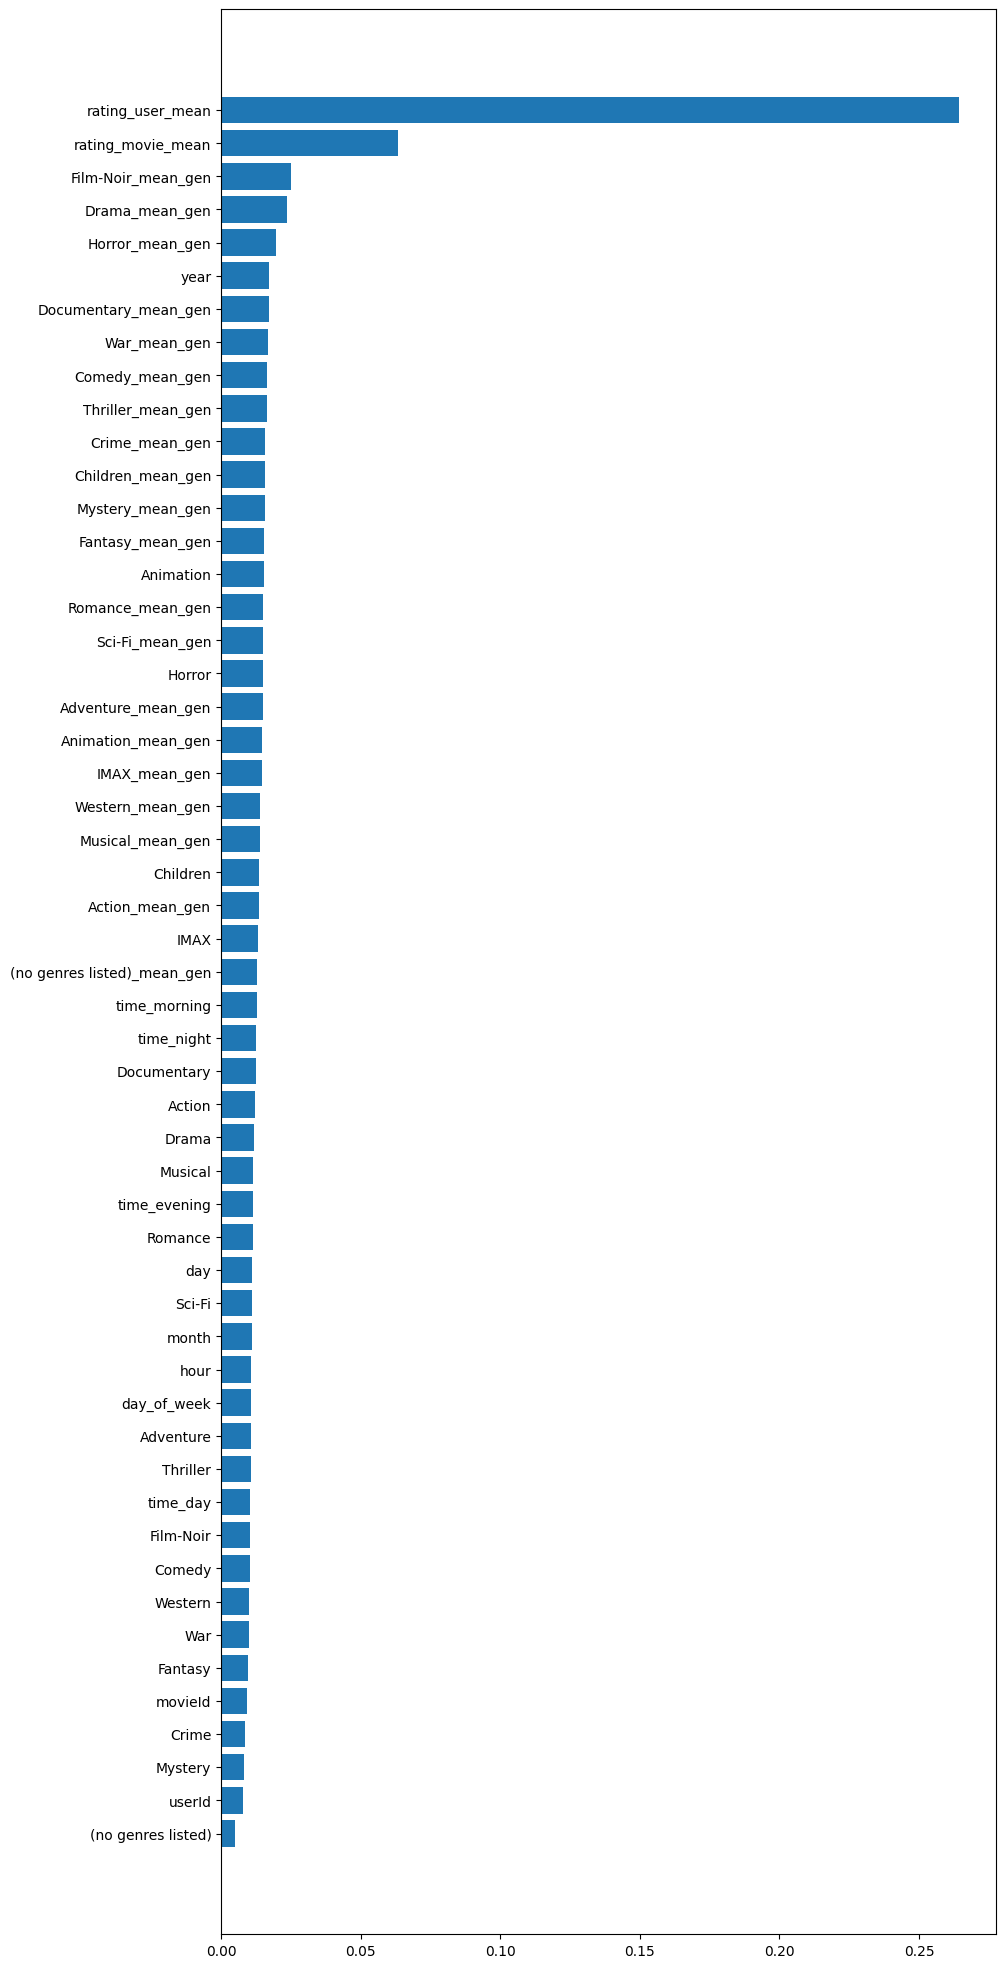

In [43]:
import matplotlib.pyplot as plt
best_model.feature_importances_
sorted_idx = best_model.feature_importances_.argsort()
plt.figure(figsize=(10,25))
plt.barh(X_test.columns[sorted_idx], best_model.feature_importances_[sorted_idx])